In [1]:
import csv
import numpy as np
from math import *
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
data = []
with open('clusters.txt') as file:
    reader = csv.reader(file)
    for line in reader:
        data.append([float(line[0]),float(line[1])])

# k-means

In [384]:
def initial_centroids(data, k):
    num_samples, dim = np.array(data).shape
    centroids = np.zeros((k, dim))
    idx = np.random.randint(len(data), size=3)
    for i in range(k):
        centroids[i] = data[idx[i]]
    return centroids

In [385]:
def min_distance(p1, p2):
    return sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

In [386]:
def update2centroids(datapoint, centroids):
    k_num_distance = []
    for c in centroids:
        d = min_distance(c, datapoint)
        k_num_distance.append(d)
    return np.argmin(k_num_distance)

In [387]:
def clasify2cluster(data, k, centroids, cluster):
    cluster=[[] for i in range(k)]
    for p in data:
        c_idx = update2centroids(p, centroids)
        cluster[c_idx].append(p)
    # find new centroids from the clusters
    num_samples, dim = np.array(data).shape
    new_centroids = np.zeros((k, dim))
    for i in range(k):
        new_x = np.array(cluster[i])[:,0].mean()
        new_y = np.array(cluster[i])[:,1].mean()
        new_centroids[i] = [new_x,new_y]
        difference = new_centroids - centroids
    return (difference, new_centroids, cluster)

In [388]:
def kmeans(data, k):
    mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']
    centroids_dict = {'cluster1':[],'cluster2':[],'cluster3':[]}
    cluster=[[] for i in range(k)]
    centroids = initial_centroids(data, k)
    centroids_dict['cluster1'].append(tuple(centroids[0]))
    centroids_dict['cluster2'].append(tuple(centroids[1]))
    centroids_dict['cluster3'].append(tuple(centroids[2]))
    difference, new_centroids, cluster = clasify2cluster(data, k, centroids, cluster)
    while np.any(difference != 0):
        cluster=[[] for i in range(k)]
        difference, new_centroids, cluster = clasify2cluster(data, k, new_centroids, cluster)
#         print(new_centroids)
        for i in range(3):
            plt.plot(np.array(cluster[i])[:,0],np.array(cluster[i])[:,1],mark[i])
        plt.show()
        centroids_dict['cluster1'].append(tuple(new_centroids[0]))
        centroids_dict['cluster2'].append(tuple(new_centroids[1]))
        centroids_dict['cluster3'].append(tuple(new_centroids[2]))
#         for key_index in range(3):
#             centroids_dict[list(centroids_dict.keys())[i]].append(new_centroids[i])
    return (difference, new_centroids, cluster, centroids_dict)

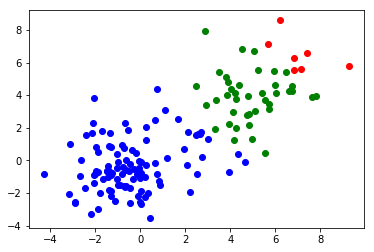

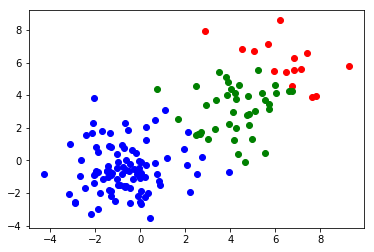

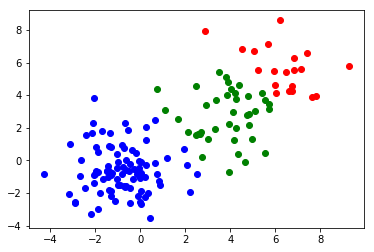

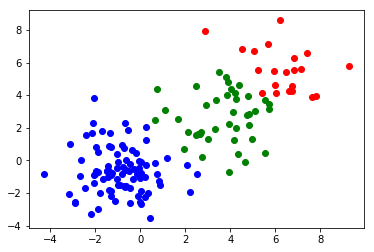

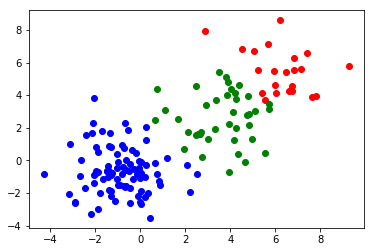

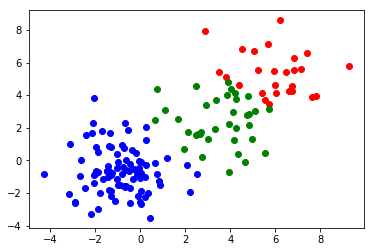

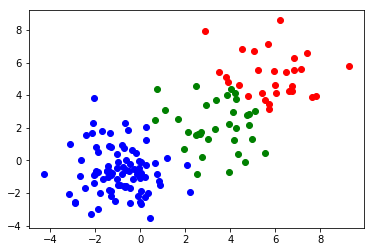

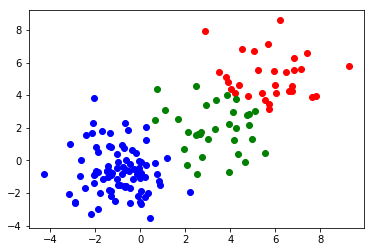

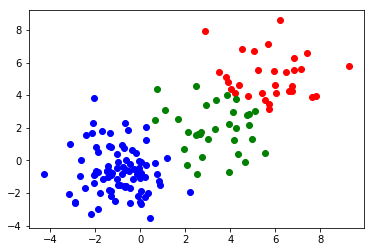

In [390]:
difference, new_centroids, cluster, centroids_dict = kmeans(data, 3)

In [391]:
df = pd.DataFrame(centroids_dict)
df

,cluster1,cluster2,cluster3
0,"(9.24625283, 5.798154028)","(4.332341441, 0.379144641)","(7.6139873, 3.886738434)"
1,"(7.046183187285714, 6.504576220285714)","(-0.39503845620388345, -0.33566899328155325)","(4.87937217245, 3.920994646174999)"
2,"(6.4214513885333355, 6.02525778)","(-0.6973655013617024, -0.5281010588723403)","(4.220482793170732, 3.0990377052439024)"
3,"(6.3445781536500006, 5.66186046165)","(-0.8382861027777778, -0.5996742275444444)","(3.809084859925, 2.713284608175)"
4,"(6.300685761, 5.588236078761905)","(-0.8868890721704545, -0.6498460223295455)","(3.6473425753658537, 2.6251562290731707)"
5,"(6.265895876045454, 5.503770484590909)","(-0.8868890721704545, -0.6498460223295455)","(3.6001434324499995, 2.597535309625)"
6,"(5.969836109730769, 5.372061227576923)","(-0.8868890721704545, -0.6498460223295455)","(3.517769658833333, 2.369743642472222)"
7,"(5.850027767310345, 5.227752722448277)","(-0.9258640173218393, -0.6478508971609195)","(3.373781543382353, 2.1340032994999993)"
8,"(5.738495346032258, 5.164838081193549)","(-0.960652907023256, -0.652218412860465)","(3.2888485605151514, 1.9326883657575757)"
9,"(5.738495346032258, 5.164838081193549)","(-0.960652907023256, -0.652218412860465)","(3.2888485605151514, 1.9326883657575757)"


# GMM

In [19]:
def initial_ric(data, k):
    initial_ric = np.zeros((len(data), k))
    random_int = np.random.randint(low=1,high=10000,size=(len(data), k))
    for row in range(len(random_int)):
        initial_ric[row] = random_int[row]/sum(random_int[row])
    return initial_ric

In [6]:
def caluculate_new_mu(k, ric, data):
    new_mu = np.zeros((k, 2))
    # calculate the mu of each cluster
    for c_index in range(k):
        # loop all datapoints and their corresponding ric
        for r, p in zip(ric[:,c_index], np.array(data)):
            new_mu[c_index] += r*p
        new_mu[c_index] = new_mu[c_index] / sum(ric[:,c_index])
    return new_mu

In [7]:
def caluculate_new_sigma(k, ric, data, mu):
    new_sigma = np.array([[[0, 0], [0, 0]] for i in range(0,k)], dtype='float64')
    for c_index in range(k):
        # loop all datapoints and their corresponding ric
        for r, p in zip(ric[:,c_index], np.array(data)):
            new_sigma[c_index] += r*np.outer(p-mu[c_index],p-mu[c_index])
        new_sigma[c_index] = new_sigma[c_index] / sum(ric[:,c_index])
    return new_sigma

In [8]:
def caluculate_new_pi(k, ric, data):
    new_pi = np.zeros(k)
    for idx in range(k):
        new_pi[idx] = sum(ric[:,idx]) / len(data)
    return new_pi

In [9]:
def update_ric(k, data, mu, sigma, pi):
    pdfs = np.zeros(((len(data), k)))
    for i in range(k):
        pdfs[:, i] = pi[i] * multivariate_normal.pdf(data, mu[i], sigma[i])
    ric = pdfs / pdfs.sum(axis=1).reshape(-1, 1)
    return ric

In [20]:
def GMM(data, k):
    param_dict = {'mu':[],'covariance':[],'pi':[]}
    diff = float('Inf')
    ric = initial_ric(data, k)
    while np.any(abs(diff) > 0.005):
        mu = caluculate_new_mu(k, ric, data)
        sigma = caluculate_new_sigma(k, ric, data, mu)
        pi = caluculate_new_pi(k, ric, data)
        new_ric = update_ric(k, data, mu, sigma, pi)
        # store all updated parameters for each iteration of GMM
        param_dict['mu'].append(mu)
        param_dict['covariance'].append(sigma)
        param_dict['pi'].append(pi)
        diff = new_ric - ric
        ric = new_ric
        # classify and store the data points into list
        cluster=[[] for i in range(k)]
        for idx in range(len(ric)):
            c_idx = np.argmax(ric[idx])
            cluster[c_idx].append(data[idx])
    # plot the cluster result    
    for i in range(3):
        mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']
        plt.plot(np.array(cluster[i])[:,0],np.array(cluster[i])[:,1],mark[i])
    plt.show()
    return (mu, sigma, pi, ric, param_dict)

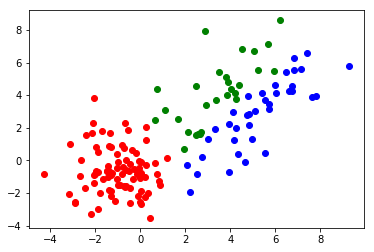

In [21]:
mu, sigma, pi, ric, param_dict = GMM(data, 3)

In [29]:
print('mu')
print(param_dict['mu'][-1])
print('\ncovariance')
print(param_dict['covariance'][-1])
print('\npi')
print(param_dict['pi'][-1])

mu
[[-0.994437   -0.63388089]
 [ 4.92603572  2.94483694]
 [ 3.83434248  3.69019296]]

covariance
[[[ 1.18193522 -0.0816692 ]
  [-0.0816692   2.02109235]]

 [[ 3.50297936  2.97191914]
  [ 2.97191914  4.33618297]]

 [[ 3.44038384  2.08056859]
  [ 2.08056859  5.46032776]]]

pi
[0.55921906 0.20585555 0.23492538]


In [25]:
df2 = pd.DataFrame(param_dict)
df2

,mu,covariance,pi
0,"[[1.1007248278513764, 0.9667425751037227], [1....","[[[8.792086321420031, 5.631038057533147], [5.6...","[0.3217369636394014, 0.36242783541032936, 0.31..."
1,"[[1.0473299327398078, 0.9469008177782167], [1....","[[[8.599769697248709, 5.4694270222150445], [5....","[0.32203643933644927, 0.3623754124633316, 0.31..."
2,"[[0.9775956932572456, 0.9174269423334629], [1....","[[[8.400474307196058, 5.29608962005782], [5.29...","[0.32226704339363277, 0.3624886735510926, 0.31..."
3,"[[0.8910565623903051, 0.8772627067952585], [1....","[[[8.160975827546569, 5.087335508243102], [5.0...","[0.3225036853052084, 0.3627506140040461, 0.314..."
4,"[[0.7846818414102559, 0.8222582758528695], [1....","[[[7.857506462774253, 4.8231344182609], [4.823...","[0.32274779439466095, 0.3632044479648774, 0.31..."
5,"[[0.6531770374912677, 0.7447856268413947], [1....","[[[7.463638208764098, 4.478287050494891], [4.4...","[0.323016396335535, 0.36386017178901575, 0.313..."
6,"[[0.4886928311455358, 0.6335251280537156], [1....","[[[6.94124955422891, 4.0148950539404336], [4.0...","[0.3234327861520789, 0.3646023510008851, 0.311..."
7,"[[0.281086135000567, 0.4748785761288602], [1.8...","[[[6.235497115872122, 3.3815132425807044], [3....","[0.32444237274592697, 0.3650564985972611, 0.31..."
8,"[[0.022317815245888658, 0.26020852377491965], ...","[[[5.287453427680447, 2.538089776877809], [2.5...","[0.32732378875694434, 0.3643674766730098, 0.30..."
9,"[[-0.279402864490466, 0.0033695469408789713], ...","[[[4.102099013196089, 1.540731961427065], [1.5...","[0.3350435972732141, 0.3607933951884801, 0.304..."
